# Практика застосування логістичної регресії

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

### Завантажуємо набір даних Rain in Australia

In [4]:
data = pd.read_csv('../datasets/mod_03_topic_05_weather_data.csv.gz')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Видаляємо ознаки з великою кількістю пропущених значень

In [7]:
data = data[data.columns[data.isna().mean().lt(0.35)]]
data = data.dropna(subset='RainTomorrow')

### Створюємо підмножини із числовими та категоріальними ознаками

In [6]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

### Змінюємо тип Date на тип datetime і створюємо колонки Year та Month

In [8]:
data_cat['Date'] = pd.to_datetime(data['Date'])

data_cat[['Year', 'Month']] = (data_cat['Date']
                               .apply(lambda x:
                                      pd.Series([x.year, x.month])))

data_cat.drop('Date', axis=1, inplace=True)

data_cat[['Year', 'Month']] = data_cat[['Year', 'Month']].astype(str)

data_cat[['Year', 'Month']].head()

,Year,Month
0,2008,12
1,2008,12
2,2008,12
3,2008,12
4,2008,12


### Переміщуємо колонку Year до підмножини із числовими ознаками

In [9]:
data_num['Year'] = data_cat['Year'].astype(int)
data_cat.drop('Year', axis=1, inplace=True)

### Розбиваємо підмножини на тренувальну і тестову вибірки за роками за допомогою булевої індексації

In [10]:
last_year = data_num['Year'].max()

train_mask = data_num['Year'] < last_year
test_mask = data_num['Year'] == last_year

X_train_num = data_num[train_mask]
X_test_num = data_num[test_mask]
X_train_cat = data_cat[train_mask].drop('RainTomorrow', axis=1)
X_test_cat = data_cat[test_mask].drop('RainTomorrow', axis=1)
y_train = data[train_mask]['RainTomorrow']
y_test = data[test_mask]['RainTomorrow']

### Відновлюємо пропущені дані числових ознак

In [11]:
num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

pd.concat([X_train_num, X_test_num]).isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
Year             0
dtype: int64

### Відновлюємо пропущені дані категоріальних ознак

In [12]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

pd.concat([X_train_cat, X_test_cat]).isna().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
Month          0
dtype: int64

### Нормалізуємо числові ознаки

In [13]:
scaler = StandardScaler().set_output(transform='pandas')

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

### Виконаємо кодування категоріальних ознак

In [14]:
encoder = (OneHotEncoder(drop='if_binary',
                         sparse_output=False)
           .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

### Об'єднаємо підмножини з числовими і категоріальними ознаками

In [15]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

### Створюємо і навчаємо модель

In [16]:
clf = (LogisticRegression(solver='liblinear',
                          class_weight='balanced',
                          random_state=42)
       .fit(X_train, y_train))

pred = clf.predict(X_test)

### Оцінюємо точність моделі

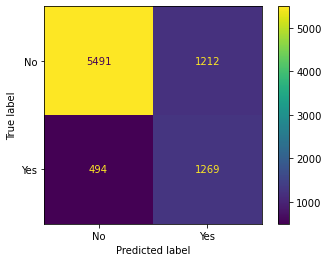

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

### Розрахуємо метрики моделі

In [18]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.51      0.72      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.71      0.77      0.73      8466
weighted avg       0.83      0.80      0.81      8466



## Висновки

### 1. Точність (precision)

Точність залишилася на тому ж рівні:

- для класу No - 0.92
- для класу Yes - 0.51

### 2. Повнота (Recall)

- для класу No повнота трохи краща у новій моделі (0.82) порівняно з вихідною моделлю (0.79)
- для класу Yes повнота трохи гірша у новій моделі (0.72) порівняно з вихідною моделлю (0.76)

### 3. F1-score

- для класу No F1-score трохи кращий у новій моделі (0.87), ніж у вихідній (0.85)
- для класу Yes F1-score трохи гірший у новій моделі (0.60), ніж у вихідній (0.61)

### 4. Загальна точність (Accuracy)

Нова модель має точність 0.80, що трохи краще, ніж у вихідної моделі з точністю 0.79

<br>


**Таким чином, обидві моделі показують дуже схожі результати, але нова модель демонструє трохи кращу загальну точність.**